# A/B Test: A New Menu Launch

### Project Overview

You're a business analyst for Round Roasters, a coffee restaurant in the United States of America. The executive team conducted a market test with a new menu and needs to figure whether the new menu can drive enough sales to offset the cost of marketing the new menu. Your job is to analyze the A/B test and write up a recommendation to whether the Round Roasters chain should launch this new menu.

### Skills Required

In order to complete this project, you must be able to:

    Cleanup, format, and blend a wide range of data sources
    Plan and analyze A/B tests

You have been able to gather three data files to use for your analysis:

- Transaction data for all stores from 2015-January-21 to 2016-August-18
- A listing of all Round Roasters stores
- A listing of the 10 stores (5 in each market) that were used as test markets.


### Step 1: Plan Your Analysis

To perform the correct analysis, you will need to prepare a data set. Prior to rolling up your sleeves and preparing the data, it’s a good idea to have a plan of what you need to do in order to prepare the correct data set. A good plan will help you with your analysis. Here are a few questions to get you started:

- What is the performance metric you’ll use to evaluate the results of your test?
- What is the test period?
- At what level (day, week, month, etc.) should the data be aggregated?


In [2]:

# import all required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
from sklearn.neighbors import KDTree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

### Load all the datasets

In [4]:
# load roaster stores data
rrs = pd.read_csv("data/round-roaster-stores.csv")
# load treatment stores data
ts = pd.read_csv("data/treatment-stores.csv")
# load transactions stores data
rrt = pd.read_csv("data/RoundRoastersTransactions.csv", parse_dates=['Invoice Date'])

### Explore the stores dataset

In [5]:
rrs.head(3)

,StoreID,Sq_Ft,AvgMonthSales,Right_Name,Phone Number,Street Combined,Street 1,Street 2,Street 3,City,State,Postal Code,Region,Country,Coordinates,Latitude,Longitude,Timezone,Current Timezone Offset,Olson Timezone
0,10018,1183,18000,Bellflower & Spring,562-420-1317,"2890 N Bellflower Blvd, #A-1, The Los Altos Ma...",2890 N Bellflower Blvd,#A-1,The Los Altos Marketplace,Long Beach,CA,908151125,West,US,"(33.8085823059082, -118.124931335449)",33.808582,-118.124931,Pacific Standard Time,-480,GMT-08:00 America/Los_Angeles
1,10068,1198,16000,"Foothill & Boston, La Crescenta",818-541-7693,"3747 Foothill Boulevard, A",3747 Foothill Boulevard,A,NaN,La Cresenta,CA,912141700,West,US,"(34.2375450134277, -118.26114654541)",34.237545,-118.261146,Pacific Standard Time,-480,GMT-08:00 America/Los_Angeles
2,10118,1204,13000,Magic Mountain & Tourney,661-260-0844,"25349 Wayne Mills Place, Tourney Retail Plaza",25349 Wayne Mills Place,NaN,Tourney Retail Plaza,Valencia,CA,913551827,West,US,"(34.4237022399902, -118.579261779785)",34.423702,-118.579262,Pacific Standard Time,-480,GMT-08:00 America/Los_Angeles


In [6]:
rrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   StoreID                  133 non-null    int64  
 1   Sq_Ft                    133 non-null    int64  
 2   AvgMonthSales            133 non-null    int64  
 3   Right_Name               133 non-null    object 
 4   Phone Number             130 non-null    object 
 5   Street Combined          133 non-null    object 
 6   Street 1                 133 non-null    object 
 7   Street 2                 37 non-null     object 
 8   Street 3                 25 non-null     object 
 9   City                     133 non-null    object 
 10  State                    133 non-null    object 
 11  Postal Code              133 non-null    int64  
 12  Region                   133 non-null    object 
 13  Country                  133 non-null    object 
 14  Coordinates              1

In [7]:
# Check missing data if any
rrs.isnull().sum()

StoreID                      0
Sq_Ft                        0
AvgMonthSales                0
Right_Name                   0
Phone Number                 3
Street Combined              0
Street 1                     0
Street 2                    96
Street 3                   108
City                         0
State                        0
Postal Code                  0
Region                       0
Country                      0
Coordinates                  0
Latitude                     0
Longitude                    0
Timezone                     0
Current Timezone Offset      0
Olson Timezone               0
dtype: int64

### Explore treatment stores dataset

In [8]:
ts.head(3)

,StoreID,Sq_Ft,AvgMonthSales,Phone Number,Street Combined,Street 1,Street 2,Street 3,City,Postal Code,Region,Country,Coordinates,Latitude,Longitude,Timezone,Current Timezone Offset,Olson Timezone,Name,Right_State
0,1664,1475,11000,8478428048,"101 W. Main St., Barrington Village Center",101 W. Main St.,NaN,Barrington Village Center,Barrington,60010,Central,US,"(42.1540565490723, -88.1362915039063)",42.154057,-88.136291,Central Standard Time,-360,GMT-06:00 America/Chicago,Barrington,IL
1,1675,1472,15000,8472531188,90 East Northwest Highway,90 East Northwest Highway,NaN,NaN,Mount Prospect,60056,Central,US,"(42.0633544921875, -87.9355773925781)",42.063354,-87.935577,Central Standard Time,-360,GMT-06:00 America/Chicago,Northwest Hwy & Elmhurst Rd,IL
2,1696,1471,10000,2242232528,1261 East Higgins Road,1261 East Higgins Road,NaN,NaN,Schaumburg,60173,Central,US,"(42.039363861084, -88.048828125)",42.039364,-88.048828,Central Standard Time,-360,GMT-06:00 America/Chicago,Higgins & Meacham,IL


In [9]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   StoreID                  10 non-null     int64  
 1   Sq_Ft                    10 non-null     int64  
 2   AvgMonthSales            10 non-null     int64  
 3   Phone Number             9 non-null      object 
 4   Street Combined          10 non-null     object 
 5   Street 1                 10 non-null     object 
 6   Street 2                 1 non-null      float64
 7   Street 3                 1 non-null      object 
 8   City                     10 non-null     object 
 9   Postal Code              10 non-null     int64  
 10  Region                   10 non-null     object 
 11  Country                  10 non-null     object 
 12  Coordinates              10 non-null     object 
 13  Latitude                 10 non-null     float64
 14  Longitude                10 n

In [10]:
# check missing values
ts.isnull().sum()

StoreID                    0
Sq_Ft                      0
AvgMonthSales              0
Phone Number               1
Street Combined            0
Street 1                   0
Street 2                   9
Street 3                   9
City                       0
Postal Code                0
Region                     0
Country                    0
Coordinates                0
Latitude                   0
Longitude                  0
Timezone                   0
Current Timezone Offset    0
Olson Timezone             0
Name                       0
Right_State                0
dtype: int64

### Explore the transaction dataset


In [11]:
rrt.head(3)

,StoreID,Invoice Number,Invoice Date,SKU,Category,Product,QTY,Size,Gross Margin,Sales
0,10018,16296643,2015-01-21,1043,Espresso,Mocha,3,L,6.7365,14.97
1,10018,16296643,2015-01-21,2001,Pastry,Croissant,1,NaN,1.1000,2.75
2,10018,16297717,2015-01-21,1021,Espresso,Espresso,3,S,4.1850,8.37


In [12]:
rrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332333 entries, 0 to 4332332
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   StoreID         int64         
 1   Invoice Number  int64         
 2   Invoice Date    datetime64[ns]
 3   SKU             int64         
 4   Category        object        
 5   Product         object        
 6   QTY             int64         
 7   Size            object        
 8   Gross Margin    float64       
 9   Sales           float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 330.5+ MB


In [13]:
# check missing values
rrt.isnull().sum()

StoreID                0
Invoice Number         0
Invoice Date           0
SKU                    0
Category               0
Product                0
QTY                    0
Size              942725
Gross Margin           0
Sales                  0
dtype: int64

### Step 2: Clean Up Your Data

In this step, you should prepare the data for steps 3 and 4. You should aggregate the transaction data to the appropriate level and filter on the appropriate data ranges. You can assume that there is no missing, incomplete, duplicate, or dirty data. You’re ready to move on to the next step when you have weekly transaction data for all stores.

### Aggregate and Export

We recommend you save your aggregated transaction database as a separate file to further reduce your development time. You shouldn't need to re-aggregate the transaction database every time you want to test out a new workflow.
### Creating a week variable

When calculating the week column, assign week 1 to the first week of the test period, so the week_begin variable for week 1 would be your test start date. This will cause weeks prior to the test period to be negative, which is perfectly fine. 

### Number of Weeks

Create trend and seasonality variables to use as control variables. To do this, you need at least 52 weeks of data, plus the number of weeks you select in the tool to calculate trend, before the beginning of the test start date. In lesson 4, you used 6 weeks to calculate the trend, so you needed 58 weeks prior to the test start date. For the project, you are asked to use 12 weeks to calculate trend, so you'll need 64 weeks of data prior to the test start date. Since the test lasts for 12 weeks, this means you'll need a total 76 weeks of data.

Your filter at the beginning of your workflow should go back 76 weeks from the end of the test period 2016-July-21. The expression shuold look like `[Invoice Date]>="2015-02-06" AND [Invoice Date]<"2016-07-22"`

All stores should have 76 weeks of Data.

In [14]:
from datetime import datetime, timedelta

To do this, we have given the following bench marks

`invoice_end_date = 2016-07-21`

`treatment = 12 weeks` - 2016-04-29 - 2016-7-21, start on Friday

`control = 12 weeks` - 2015-04-29 - 2015-7-21, start on Wednesday

`Total weeks = 52 weeks + 12 + 12 = 76 weeks`


Let's calculate the exact start date to filter the transaction

In [15]:
invoice_end_date = datetime(2016, 7, 21)
invoice_start_date = invoice_end_date - timedelta(weeks=76)

In [16]:
print(invoice_start_date, "-", invoice_end_date)

2015-02-05 00:00:00 - 2016-07-21 00:00:00


The type of the date we have calcuated above is `datetime.datetime`. We will get the date only.

In [17]:
type(invoice_end_date)

datetime.datetime

In [18]:
# convert to datetime format
invoice_start_date = pd.to_datetime(invoice_start_date, format="%Y-%m-%d")
invoice_end_date = pd.to_datetime(invoice_end_date, format="%Y-%m-%d")

In [19]:
print(invoice_start_date, invoice_end_date)

2015-02-05 00:00:00 2016-07-21 00:00:00


Filter the transaction data with the start and end date of the invoice. In the transaction dataset, the `Invoice Date` type is object. Comparing two different types are not possible therefore, we will convert the `Invoice Date` column to `Datetime64` type.

In [20]:
# converting into datetime
rrt['Invoice Date'] = pd.to_datetime(rrt['Invoice Date'])

In [21]:
# filtering the transaction data between start and end date
trans_ = rrt[((rrt['Invoice Date'] > pd.to_datetime(invoice_start_date)) & (rrt['Invoice Date'] <= pd.to_datetime(invoice_end_date)))]

In [22]:
# Set the Invoice Date column to index
#trans_.set_index('Invoice Date', inplace=True)

In [23]:
display('The start date invoice data', trans_.head(), "The end date invoice data", trans_.tail())

'The start date invoice data'

,StoreID,Invoice Number,Invoice Date,SKU,Category,Product,QTY,Size,Gross Margin,Sales
628,10018,16551067,2015-02-06,1013,Espresso,Cappuccino,2,L,4.7880,7.98
629,10018,16551067,2015-02-06,1022,Espresso,Espresso,1,M,1.4950,2.99
630,10018,16551067,2015-02-06,1023,Espresso,Espresso,3,L,4.7850,9.57
631,10018,16551067,2015-02-06,1041,Espresso,Mocha,1,S,1.7955,3.99
632,10018,16551067,2015-02-06,1042,Espresso,Mocha,3,M,6.0615,13.47


'The end date invoice data'

,StoreID,Invoice Number,Invoice Date,SKU,Category,Product,QTY,Size,Gross Margin,Sales
4332328,9968,45360178,2016-07-21,1043,Espresso,Mocha,3,L,6.7365,14.97
4332329,9968,45360179,2016-07-21,1043,Espresso,Mocha,1,L,2.2455,4.99
4332330,9968,45360242,2016-07-21,1041,Espresso,Mocha,2,S,3.5910,7.98
4332331,9968,45360243,2016-07-21,1043,Espresso,Mocha,4,L,8.9820,19.96
4332332,9968,45360705,2016-07-21,2001,Pastry,Croissant,3,NaN,3.3000,8.25


Aggregate the data to get the weekly gross margin and weekly traffic count (count of unique invoices)
To do this, resampling the Invoice date from Wednesday to Friday.

In [24]:
# set the invoice date to index column
trans_.set_index('Invoice Date', inplace=True)

In [25]:

#trans_agg = trans_.set_index('Invoice Date').groupby('StoreID').resample("W-FRI").agg({'Gross Margin':'sum','Invoice Number': 'nunique'}).reset_index()
trans_agg = trans_.groupby([pd.Grouper(freq='W-FRI', closed='left'), 'StoreID']).agg({'Gross Margin':'sum',
                                                                         'Invoice Number': 'nunique'}).reset_index()

In [26]:

# Offset the date that to start week on first date, 1w = 1 week before the transccation starts!  
trans_agg['Invoice Date'] = trans_agg['Invoice Date'] - pd.offsets.Week(1)
trans_agg.rename(columns={'Invoice Number':'Weekly Traffic Count'}, inplace=True)

### Calculate the Trend and Seasonal using Decomposition of Time Series approach

There are a couple of models to consider during the Decomposition of Time Series data.
But, I used `Additive Model`: This model is used when the variations around the trend does not vary with the level of the time series. Here the components of a time series are simply added together using the formula:
`y(t) = Level(t) + Trend(t) + Seasonality(t) + Noise(t)`. We also import `statsmodel` to do this Time series decomposition


In [27]:
import statsmodels.api as sm

In [28]:
decomposition = sm.tsa.seasonal_decompose(trans_agg['Weekly Traffic Count'], period=12, extrapolate_trend='freq', model='Addictive')
# Find trend and seasonal from the decomposition and add to the weekly gross data
trend, seasonal = decomposition.trend, decomposition.seasonal
trans_ = trans_agg.assign(Trend = decomposition.trend, Seasonal = decomposition.seasonal)

#### Label the data as treatment and control stores
We should consider the following 3 numeric variables while measures to match `treatment and control` stores.
1. Trend
2. Seasonality
3. AvgMonthSales (This should be determined by looking at the correlation between the appropriate numeric variables in the round roasters stores file `AvgMonthSales and Sq_ft` with the performance metric `gross margin`.) - This variable is in the `round-roaster-stores.csv` file.
Then

In [29]:
# merge weekly transactions and stores data 
trans_ = trans_.merge(rrs[['StoreID','Sq_Ft', 'AvgMonthSales', 'Region']], on='StoreID')

Then, label the data as treatment if the `StoreID` is found in `treatment-stores.csv` file, else `Control`.

In [30]:
trans_['Group'] = trans_['StoreID'].apply(lambda x: 'Treatment' if x in ts['StoreID'] else 'Control')
trans_.head()

,Invoice Date,StoreID,Gross Margin,Weekly Traffic Count,Trend,Seasonal,Sq_Ft,AvgMonthSales,Region,Group
0,2015-02-06,1508,1429.4390,183,207.411568,0.653029,1457,12000,Central,Control
1,2015-02-13,1508,2031.2580,273,230.041667,-2.668948,1457,12000,Central,Control
2,2015-02-20,1508,1022.0430,153,230.750000,-3.644147,1457,12000,Central,Control
3,2015-02-27,1508,1372.2495,210,229.333333,2.524783,1457,12000,Central,Control
4,2015-03-06,1508,1698.8590,239,237.750000,2.459223,1457,12000,Central,Control


To make sure that our aggregation is correct we should get 308 transaction for `StoreID==10018` and Start week in `2015-02-06`.

**Q:** How many transactions did you get for Store 10018 in the week starting 2015-02-06?

In [31]:
trans_[((trans_['StoreID'] == 10018) & (trans_['Invoice Date'] =='2015-02-06'))]

,Invoice Date,StoreID,Gross Margin,Weekly Traffic Count,Trend,Seasonal,Sq_Ft,AvgMonthSales,Region,Group
7068,2015-02-06,10018,2212.7105,308,290.125,-0.078252,1183,18000,West,Control


#### Filter the test data per store. The test start date is  `2016-04-29`. In this case there are pre and post test data.
The test data is 12 weeks.

pre test start and end weeks: `2015-04-29 - 2015-07-21`

and post test start and end weeks are: `2016-04-29 - 2016-07-21`. Based on this we can filter the test data as following:

In [32]:
# Filter Post and Pre test data
post_data = trans_.query('`Invoice Date` >= @datetime(2016, 4, 29)')
pre_data = trans_.query('`Invoice Date` >= @datetime(2015, 4, 29) and `Invoice Date` <= @datetime(2015, 7, 21)')

pre_data.head()


,Invoice Date,StoreID,Gross Margin,Weekly Traffic Count,Trend,Seasonal,Sq_Ft,AvgMonthSales,Region,Group
12,2015-05-01,1508,1701.9960,230,227.291667,0.653029,1457,12000,Central,Control
13,2015-05-08,1508,1551.2640,216,220.958333,-2.668948,1457,12000,Central,Control
14,2015-05-15,1508,1551.1995,204,217.625000,-3.644147,1457,12000,Central,Control
15,2015-05-22,1508,1626.8105,228,202.000000,2.524783,1457,12000,Central,Control
16,2015-05-29,1508,937.5550,125,195.958333,2.459223,1457,12000,Central,Control


In [33]:
# Aggregate the pre and post test stores data of each store
def agg_test_data(df, agg_cols):
    return df.groupby(['StoreID'], as_index=False).agg(agg_cols)
    
# Aggregate Columns
agg_cols ={'Gross Margin': 'sum', 'Weekly Traffic Count':'sum', 
           'Trend':'sum', 'Seasonal':'sum', 'Sq_Ft':'first', 
           'AvgMonthSales':'first', 'Region':'first', 'Group':'first'}
# code drive
pre_data_per_store = agg_test_data(pre_data, agg_cols)
post_data_per_store = agg_test_data(post_data, agg_cols)

# Print the pre and post test stores data
display(pre_data_per_store.head(), post_data_per_store.head())

,StoreID,Gross Margin,Weekly Traffic Count,Trend,Seasonal,Sq_Ft,AvgMonthSales,Region,Group
0,1508,17896.2480,2442,2636.250000,4.440892e-16,1457,12000,Central,Control
1,1542,16942.4025,2249,2652.791667,2.220446e-16,1506,12000,Central,Control
2,1580,18832.4595,2613,2697.708333,0.000000e+00,1568,14000,Central,Control
3,1630,23771.1470,3253,2751.875000,0.000000e+00,1582,17000,Central,Control
4,1662,14782.2220,1984,2712.125000,0.000000e+00,1471,11000,Central,Control


,StoreID,Gross Margin,Weekly Traffic Count,Trend,Seasonal,Sq_Ft,AvgMonthSales,Region,Group
0,1508,19035.5010,2516,2635.708333,0.000000e+00,1457,12000,Central,Control
1,1542,20272.3985,2918,2711.875000,4.440892e-16,1506,12000,Central,Control
2,1580,18698.5225,2567,2800.458333,1.110223e-16,1568,14000,Central,Control
3,1630,21627.3460,2797,2991.041667,2.220446e-16,1582,17000,Central,Control
4,1662,12714.1125,1703,3066.041667,-1.110223e-16,1471,11000,Central,Control


### Step 3: Match Treatment and Control Units

In this step, you should create the trend and seasonality variables, and use them along with you other control variable(s) to match two control units to each treatment unit. Treatment stores should be matched to control stores in the same region. Note: Calculate the number of transactions per store per week and use 12 periods to calculate trend and seasonality.

##### Apart from trend and seasonality...
- What control variables should be considered? Note: Only consider variables in the RoundRoastersStore file
- What is the correlation between your each potential control variable and your performance metric? (Example of correlation matrix below)
- What control variables will you use to match treatment and control stores?


### Step 4: Analysis and Writeup

Conduct your A/B analysis and create a short report outlining your results and recommendations. 

In an AB Analysis we use the correlation matrix to find the most correlated variable to the performance metric to include in the AB controls tool to help find the best matches.

In [34]:
# Pearson Correlation Matrix of  Gross Margin and Stores variables

pre_data_per_store[['Gross Margin', 'Sq_Ft', 'AvgMonthSales']].corr().round(2)
#plt.title("Pearson Correlation Analysis")

,Gross Margin,Sq_Ft,AvgMonthSales
Gross Margin,1.00,-0.04,0.98
Sq_Ft,-0.04,1.00,-0.05
AvgMonthSales,0.98,-0.05,1.00


In [35]:
# Match Pre Treatment and Control Stores Data
pre_control_stores = pre_data_per_store.query('Group == "Control"').reset_index(drop=True)
pre_treatment_stores = pre_data_per_store.query('Group == "Treatment"').reset_index(drop=True)

# filter region data
# Region: 'Central'
pre_control_central = pre_control_stores.query('Region == "Central"').reset_index(drop=True)
pre_treatment_central = pre_treatment_stores.query('Region == "Central"').reset_index(drop=True)

# Region: 'West'
pre_control_west = pre_control_stores.query('Region == "West"').reset_index(drop=True)
pre_treatment_west = pre_treatment_stores.query('Region == "West"').reset_index(drop=True)

In [36]:
 # Scale and transform categorical Data
transformer = ColumnTransformer([('scaler', StandardScaler(), ['Trend', 'Seasonal', 'AvgMonthSales'])], remainder='drop')
transformer.fit(pre_control_stores)
            

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Trend', 'Seasonal', 'AvgMonthSales'])])

In [37]:
# Matched Treatment and Stores - version: 2
# return: 'Treatment store ID', 'Control store ID', 'Pre Gross Treatment', 'Pre Gross Control'

def get_matched_pairs(region_control_data, region_treatment_data):
    treatment_ids = []
    control_ids = []
    treatment_store_gross = []
    control_store_gross = []

    kdtree = KDTree(transformer.transform(region_control_data), leaf_size=2)

    for i , treat_store_id in enumerate(region_treatment_data['StoreID']):
        treatment_ids += [treat_store_id, treat_store_id]
        treat_data = region_treatment_data.iloc[i:i+1]
        
        _tg = treat_data.iloc[0]['Gross Margin'] # Get column value from df with single row
        treatment_store_gross += [_tg,_tg]
        
        idx = kdtree.query(transformer.transform(treat_data), k=2, return_distance=False, dualtree=True)

        _matched = region_control_data.iloc[idx[0]]
        control_ids += list(_matched['StoreID'])
        control_store_gross += list(_matched['Gross Margin'])
    
    _x = list(zip(treatment_ids, control_ids, treatment_store_gross, control_store_gross))
    _columns = ['Treatment StoreID', 'Control StoreID', 'Treatment Pre Gross', 'Control Pre Gross']
    return pd.DataFrame(_x, columns=_columns)

In [38]:
# Find Matched Stores for Central and West Region
stores_matched_west = get_matched_pairs(pre_control_west, pre_treatment_west)
stores_matched_central = get_matched_pairs(pre_control_central, pre_treatment_central)

In [39]:
stores_matched_west

,Treatment StoreID,Control StoreID,Treatment Pre Gross,Control Pre Gross


In [40]:
# Matched Stores With Store ID's
pd.concat([stores_matched_central, stores_matched_west])[['Treatment StoreID', 'Control StoreID']]

,Treatment StoreID,Control StoreID


In [41]:
# Join Post Data to region region matched stores

def pre_post_data_report(matched_stores, post_stores_data):
    post_column = ['StoreID', 'Gross Margin']
    _psd = post_stores_data[post_column].set_index('StoreID')

    # treatment
    _res = matched_stores.join(_psd, on='Treatment StoreID').rename(columns={'Gross Margin': 'Treatment Post Gross'})
    # control
    _res = _res.join(_psd, on='Control StoreID').rename(columns={'Gross Margin': 'Control Post Gross'})

    # treatment changes
    _chg_treat = _res[['Treatment Pre Gross', 'Treatment Post Gross']].pct_change(axis=1).dropna(axis=1)
    _res['Treatment Change'] = _chg_treat * 100 # make it percentage

    # control changes
    _chg_control = _res[['Control Pre Gross', 'Control Post Gross']].pct_change(axis=1).dropna(axis=1)
    _res['Control Change'] = _chg_control * 100 # make it percentage

    return _res


In [43]:
# Region Reports
central_report = pre_post_data_report(stores_matched_central, post_data_per_store)
west_report = pre_post_data_report(stores_matched_west, post_data_per_store)

west_report

ValueError: Wrong number of items passed 2, placement implies 1

In [ ]:
# Test if region the Pre and Post Gross is not random
# West Region Test Result
s_w, p_w = ttest_ind(west_report['Treatment Pre Gross'], west_report['Treatment Post Gross'])
print('West Region Test', '\nStatistic:', s_w, '\nP-Value:', p_w, '\nSignificance: ', (1-p_w)*100)

w_chg = (west_report.sum()['Treatment Post Gross'] / west_report.sum()['Treatment Pre Gross'] - 1)*100
print('Lift:', w_chg)

# Central Region Test Result
s_c, p_c = ttest_ind(central_report['Treatment Pre Gross'], central_report['Treatment Post Gross'])
print('\nCentral Region Test', '\nStatistic:', s_c, '\nP-Value:', p_c, '\nSignificance: ', (1-p_c)*100)

c_chg = (central_report.sum()['Treatment Post Gross'] / central_report.sum()['Treatment Pre Gross'] - 1)*100
print('Lift:', c_chg)

West Region Test 
Statistic: 1.5753056750341858 
P-Value: 0.11605940056571082 
Significance:  88.39405994342891
Lift: -5.122486643250424

Central Region Test 
Statistic: -1.3710773763015067 
P-Value: 0.17220158086777032 
Significance:  82.77984191322297
Lift: 6.404899811736509


In [ ]:
# Test if overall the Pre and Post Gross is not random
# Overall Test Result
w_c_merge = pd.concat([central_report, west_report])

s_o, p_o = ttest_ind(w_c_merge['Treatment Pre Gross'], w_c_merge['Treatment Post Gross'])

print('\nOverall Test', '\nStatistic:', s_o, '\nP-Value:', p_o, '\nSignificance: ', (1-p_o)*100)
w_c_chg = (w_c_merge.sum()['Treatment Post Gross'] / w_c_merge.sum()['Treatment Pre Gross'] - 1)*100
print('Overall Lift:', w_c_chg)


Overall Test 
Statistic: 0.6687615313197577 
P-Value: 0.5039387810517668 
Significance:  49.60612189482332
Overall Lift: -1.8052289124261045


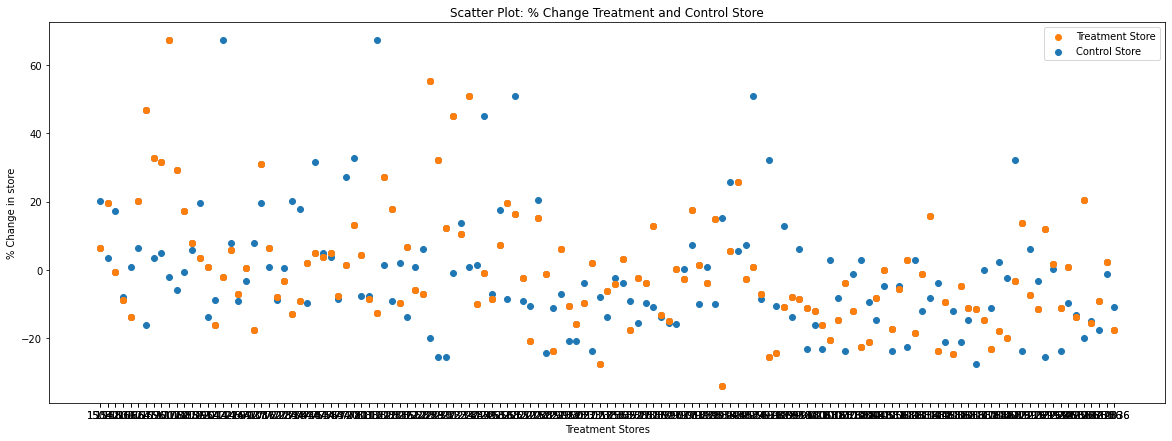

In [ ]:
# Visualazation of treatment and control change

# hack x axis to show treatment store ID
# encode treatment start with 1
x = {}
for i, id in enumerate(w_c_merge['Treatment StoreID'].unique()):
    x[id] = i+1
y = w_c_merge['Treatment StoreID'].replace(x)
w_c_merge['IDX'] = y

plt.rcParams['figure.figsize']=[20, 7]
# plor scatter with encoded treatment id as x axis
# scatter for Control Change
p1 = plt.scatter(x='IDX', y='Control Change', data=w_c_merge)
# scatter for Treatment Change
p2 = plt.scatter(x='IDX', y='Treatment Change', data=w_c_merge)
# show Treatment store ID instead on encoded value
plt.xticks(w_c_merge['IDX'], w_c_merge['Treatment StoreID'])

plt.xlabel('Treatment Stores')
plt.ylabel('% Change in store')
plt.title('Scatter Plot: % Change Treatment and Control Store')
# show legend for treatment and Control plots
plt.legend((p2, p1), ('Treatment Store', 'Control Store'))